#### references
- https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8  
    - pokemon data를 이용한 EDA

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import (NeighborhoodComponentsAnalysis,
KNeighborsClassifier)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.metrics import (
    accuracy_score, f1_score , 
    precision_score, recall_score,
    mean_squared_error,
    
    confusion_matrix
)

# load data (with drop_duplicates)

In [2]:
data = pd.read_csv("./archive/Complete Pokedex V1.1.csv").drop_duplicates()
### check duplicates
print(len(data.drop_duplicates(subset=['pokemon_name'])) == len(data))
print(data.shape)

True
(1118, 63)


In [3]:
data.head(3)

,pokedex_number,pokemon_name,type_1,type_2,ability_1,ability_2,ability_3,number_pokemon_with_typing,primary_color,shape,height,weight,bmi,hit_points,attack,defense,special_attack,special_defense,speed,total_stats,mean,standard_deviation,capture_rate,generation,base_happiness,base_experience,exp_type,exp_to_level_100,can_evolve,evolves_from,final_evolution,mega_evolution,is_default,baby_pokemon,alolan_form,galarian_form,forms_switchable,legendary,mythical,genderless,female_rate,genus,egg_group_1,egg_group_2,egg_cycles,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fighting,against_poison,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
0,1,Bulbasaur,Grass,Poison,Overgrow,Chlorophyll,NaN,15,Green,Quadruped,0.7,6.9,14.1,45,49,49,65,65,45,318,53.00,8.64,45,1,70,64,Medium Slow,1059860,True,NaN,False,False,True,False,False,False,False,False,False,False,0.125,Seed,Monster,Grass,20,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
1,2,Ivysaur,Grass,Poison,Overgrow,Chlorophyll,NaN,15,Green,Quadruped,1.0,13.0,13.0,60,62,63,80,80,60,405,67.50,8.90,45,1,70,142,Medium Slow,1059860,True,Bulbasaur,False,False,True,False,False,False,False,False,False,False,0.125,Seed,Monster,Grass,20,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
2,3,Mega Venusaur,Grass,Poison,Thick Fat,NaN,NaN,15,Green,Quadruped,2.4,155.5,27.0,80,100,123,122,120,80,625,104.17,18.75,45,6,70,281,Medium Slow,1059860,False,Ivysaur,True,True,False,False,False,False,True,False,False,False,0.125,Seed,Monster,Grass,20,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5


## handling outliers on 'weight' column

In [4]:
# Remove outliers by setting values outside of (Q1 - 1.5 * IQR) and (Q3 + 1.5 * IQR) to NaN
# data['super_heavy'] = np.where(data['weight']==10000, True, False)
super_heavy = data[data['weight']==10000]
data['weight'] = np.where(data['weight']==10000, np.nan, data['weight'])
data = data.dropna(subset=['weight']).reset_index(drop=True)

In [5]:
print(data.shape)
print(super_heavy.shape)  # removed !

(1083, 63)
(35, 63)


#### 'gmax' in name -> weight 10000

In [6]:
super_heavy.head(10)

,pokedex_number,pokemon_name,type_1,type_2,ability_1,ability_2,ability_3,number_pokemon_with_typing,primary_color,shape,height,weight,bmi,hit_points,attack,defense,special_attack,special_defense,speed,total_stats,mean,standard_deviation,capture_rate,generation,base_happiness,base_experience,exp_type,exp_to_level_100,can_evolve,evolves_from,final_evolution,mega_evolution,is_default,baby_pokemon,alolan_form,galarian_form,forms_switchable,legendary,mythical,genderless,female_rate,genus,egg_group_1,egg_group_2,egg_cycles,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fighting,against_poison,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
4,3,Venusaur Gmax,Grass,Poison,Overgrow,Chlorophyll,NaN,15,Green,Quadruped,24.0,10000.0,17.4,80,82,83,100,100,80,525,87.50,8.90,45,8,70,236,Medium Slow,1059860,False,Ivysaur,False,False,False,False,False,False,True,False,False,False,0.125,Seed,Monster,Grass,20,1.0,2.0,0.5,0.5,0.25,2.00,0.50,1.00,1.0,2.0,2.0,1.00,1.0,1.0,1.0,1.0,1.0,0.5
8,6,Charizard Gmax,Fire,Flying,Blaze,Solar Power,NaN,7,Red,Upright,28.0,10000.0,12.8,78,84,78,109,85,100,534,89.00,11.58,45,8,70,240,Medium Slow,1059860,False,Charmeleon,False,False,False,False,False,False,True,False,False,False,0.125,Flame,Monster,Dragon,20,1.0,0.5,2.0,2.0,0.25,1.00,0.50,1.00,0.0,1.0,1.0,0.25,4.0,1.0,1.0,1.0,0.5,0.5
14,9,Blastoise Gmax,Water,NaN,Torrent,Rain Dish,NaN,72,Blue,Upright,25.0,10000.0,16.0,79,83,100,85,105,78,530,88.33,10.39,45,8,70,239,Medium Slow,1059860,False,Wartortle,False,False,False,False,False,False,True,False,False,False,0.125,Shellfish,Monster,Water 1,20,1.0,0.5,0.5,2.0,2.00,0.50,1.00,1.00,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0
19,12,Butterfree Gmax,Bug,Flying,Compound Eyes,Tinted Lens,NaN,14,White,Bug-Wings,17.0,10000.0,34.6,60,45,50,90,80,70,395,65.83,15.92,45,8,70,178,Medium Fast,1000000,False,Metapod,False,False,False,False,False,False,False,False,False,False,0.500,Butterfly,Bug,NaN,15,1.0,2.0,1.0,2.0,0.25,2.00,0.25,1.00,0.0,2.0,1.0,0.50,4.0,1.0,1.0,1.0,1.0,1.0
41,25,Pikachu Gmax,Electric,NaN,Static,Lightning Rod,NaN,34,Yellow,Quadruped,21.0,10000.0,22.7,35,55,40,50,50,90,320,53.33,17.72,190,8,70,112,Medium Fast,1000000,True,Pichu,False,False,False,False,False,False,False,False,False,False,0.500,Mouse,Field,Fairy,10,1.0,1.0,1.0,0.5,1.00,1.00,1.00,1.00,2.0,0.5,1.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0
88,52,Meowth Gmax,Normal,NaN,Pickup,Technician,Unnerve,71,Yellow,Quadruped,33.0,10000.0,9.2,40,45,35,40,40,90,290,48.33,18.86,255,8,70,58,Medium Fast,1000000,True,NaN,False,False,False,False,False,False,False,False,False,False,0.500,Scratch Cat,Field,NaN,20,1.0,1.0,1.0,1.0,1.00,1.00,2.00,1.00,1.0,1.0,1.0,1.00,1.0,0.0,1.0,1.0,1.0,1.0
107,68,Machamp Gmax,Fighting,NaN,Guts,No Guard,Steadfast,29,Gray,Humanoid,25.0,10000.0,16.0,90,130,80,65,85,55,505,84.17,23.70,45,8,70,227,Medium Slow,1059860,False,Machoke,False,False,False,False,False,False,False,False,False,False,0.250,Superpower,Human-Like,NaN,20,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.0,2.0,2.0,0.50,0.5,1.0,1.0,0.5,1.0,2.0
145,94,Gengar Gmax,Ghost,Poison,Cursed Body,NaN,NaN,4,Purple,Upright,2.0,10000.0,2500.0,60,65,60,130,75,110,500,83.33,27.03,45,8,70,225,Medium Slow,1059860,False,Haunter,False,False,False,False,False,False,True,False,False,False,0.500,Shadow,Amorphous,NaN,20,0.0,1.0,1.0,1.0,0.50,1.00,0.00,0.25,2.0,1.0,2.0,0.25,1.0,2.0,1.0,2.0,1.0,0.5
152,99,Kingler Gmax,Water,NaN,Hyper Cutter,Shell Armor,Sheer Force,72,Red,Armor,19.0,10000.0,27.7,55,130,115,50,50,75,475,79.17,32.07,60,8,70,166,Medium Fast,1000000,False,Krabby,False,False,False,False,False,False,False,False,False,False,0.500,Pincer,Water 3,NaN,20,1.0,0.5,0.5,2.0,2.00,0.50,1.00,1.00,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0
193,131,Lapras Gmax,Water,Ice,Water Absorb,Shell Armor,Hydration,7,Blue,Fish,24.0,10000.0,17.4,130,85,80,85,95,60,535,89.17,21.10,45,8,70,187,Slow,1250000,False,Na

# EDA

## check columns

In [7]:
print(len(data.columns))
data.columns

63


Index(['pokedex_number', 'pokemon_name', 'type_1', 'type_2', 'ability_1',
       'ability_2', 'ability_3', 'number_pokemon_with_typing', 'primary_color',
       'shape', 'height', 'weight', 'bmi', 'hit_points', 'attack', 'defense',
       'special_attack', 'special_defense', 'speed', 'total_stats', 'mean',
       'standard_deviation', 'capture_rate', 'generation', 'base_happiness',
       'base_experience', 'exp_type', 'exp_to_level_100', 'can_evolve',
       'evolves_from', 'final_evolution', 'mega_evolution', 'is_default',
       'baby_pokemon', 'alolan_form', 'galarian_form', 'forms_switchable',
       'legendary', 'mythical', 'genderless', 'female_rate', 'genus',
       'egg_group_1', 'egg_group_2', 'egg_cycles', 'against_normal',
       'against_fire', 'against_water', 'against_electric', 'against_grass',
       'against_ice', 'against_fighting', 'against_poison', 'against_ground',
       'against_flying', 'against_psychic', 'against_bug', 'against_rock',
       'against_ghost', '

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083 entries, 0 to 1082
Data columns (total 63 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pokedex_number              1083 non-null   int64  
 1   pokemon_name                1083 non-null   object 
 2   type_1                      1083 non-null   object 
 3   type_2                      577 non-null    object 
 4   ability_1                   1083 non-null   object 
 5   ability_2                   831 non-null    object 
 6   ability_3                   518 non-null    object 
 7   number_pokemon_with_typing  1083 non-null   int64  
 8   primary_color               1083 non-null   object 
 9   shape                       1083 non-null   object 
 10  height                      1083 non-null   float64
 11  weight                      1083 non-null   float64
 12  bmi                         1083 non-null   float64
 13  hit_points                  1083 

## null data

In [9]:
null = data.isnull().sum()
null = null[null>=1]
null_columns = null.index
print(f"null values contained : {null_columns}")
null

null values contained : Index(['type_2', 'ability_2', 'ability_3', 'evolves_from', 'egg_group_2'], dtype='object')


type_2          506
ability_2       252
ability_3       565
evolves_from    563
egg_group_2     780
dtype: int64

#### check null data

In [10]:
for col in null_columns:
    print(f" # === {col} === ")
    print(f"{data[col].head(2)}\n")

 # === type_2 === 
0    Poison
1    Poison
Name: type_2, dtype: object

 # === ability_2 === 
0    Chlorophyll
1    Chlorophyll
Name: ability_2, dtype: object

 # === ability_3 === 
0    NaN
1    NaN
Name: ability_3, dtype: object

 # === evolves_from === 
0          NaN
1    Bulbasaur
Name: evolves_from, dtype: object

 # === egg_group_2 === 
0    Grass
1    Grass
Name: egg_group_2, dtype: object



## split data into 8-generation dataset

In [11]:
print(sorted(data['generation'].unique()))
gens = [ data[data['generation']==(idx+1)] for idx in range(8) ]
print([len(gens[idx]) for idx in range(8)], ": size of data for each generation")

[1, 2, 3, 4, 5, 6, 7, 8]
[151, 100, 138, 118, 165, 141, 149, 121] : size of data for each generation


# 1-1) relationships among ['height', 'weight', 'hit_points', 'attack', 'defense']

In [12]:
cols = ['height', 'weight', 'hit_points', 'attack', 'defense']

In [13]:
def remove_outliers(df, columns):
    """
    Removes outliers from a pandas DataFrame and returns a new DataFrame without them.

    Parameters:
    df (pandas.DataFrame): The DataFrame from which to remove the outliers.
    columns (list): A list of column names in the DataFrame for which to remove outliers.

    Returns:
    pandas.DataFrame: A new DataFrame with the outliers removed.
    """

    # Make a copy of the original DataFrame to avoid modifying it
    new_df = df.copy()

    # Loop through the specified columns and remove outliers using the z-score method
    for col in columns:
        z_scores = (new_df[col] - new_df[col].mean()) / new_df[col].std()
        new_df = new_df[(z_scores.abs() <= 3)]

    # Return the new DataFrame without the outliers
    return new_df

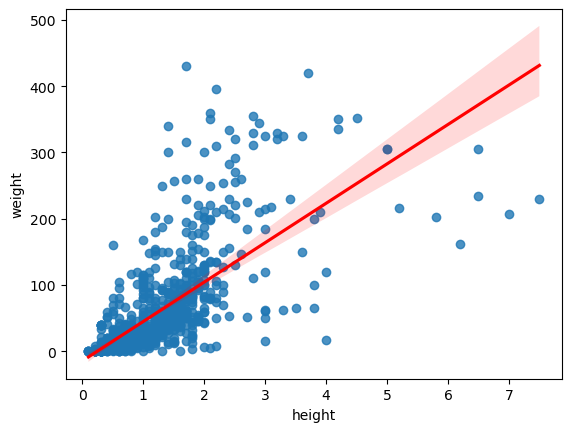

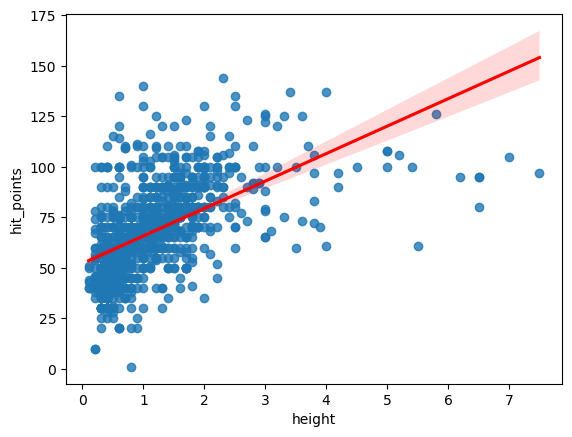

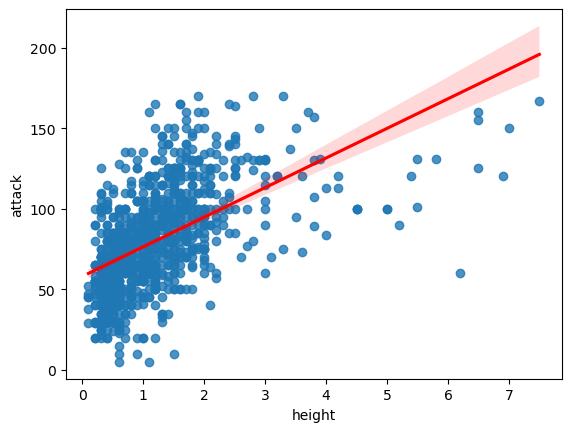

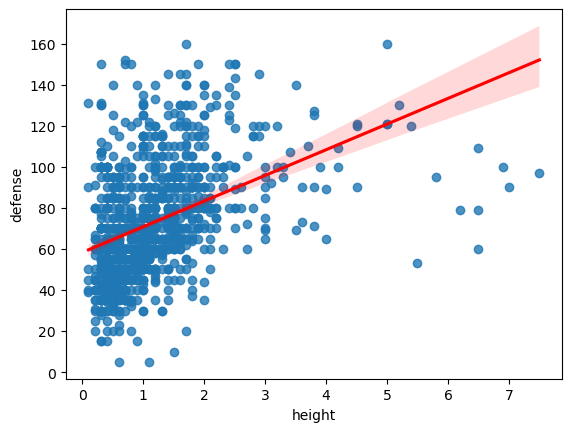

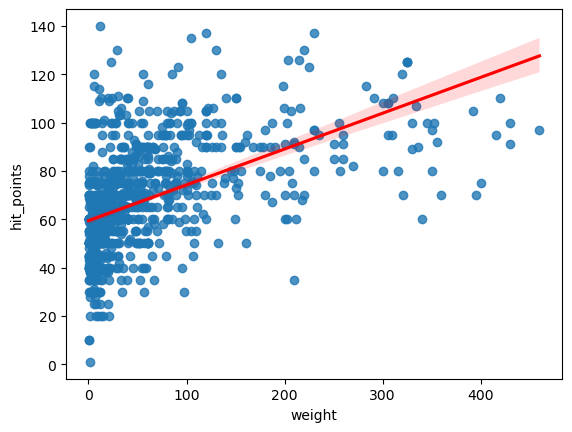

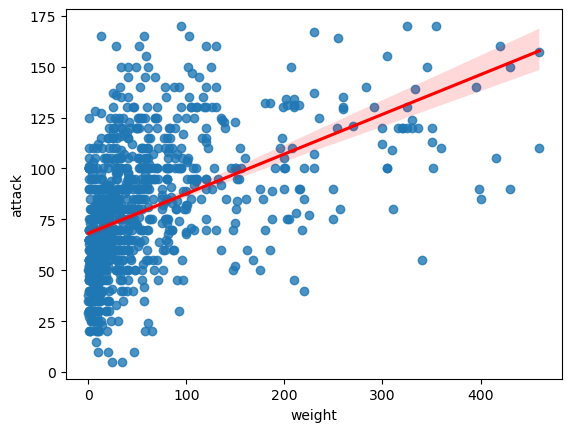

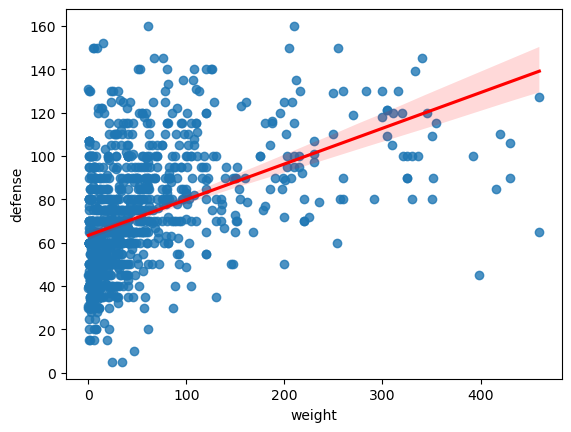

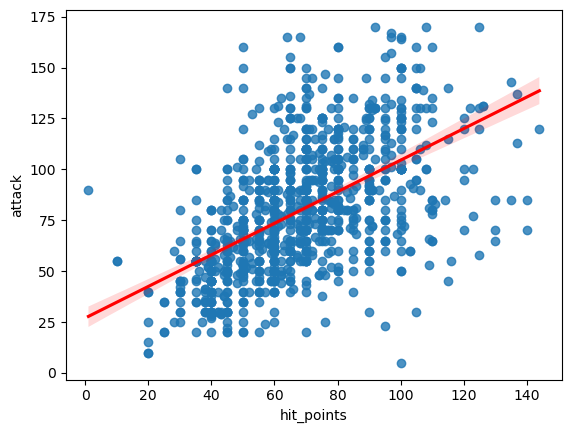

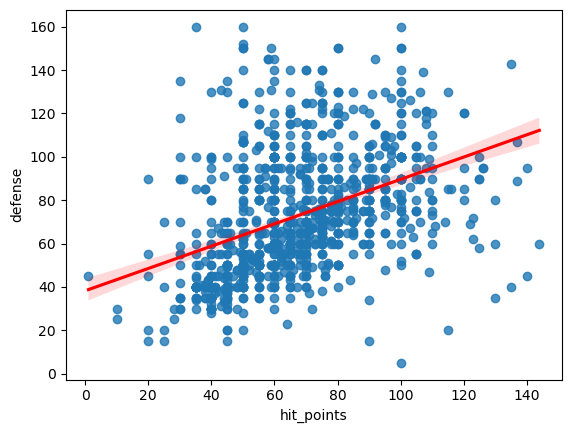

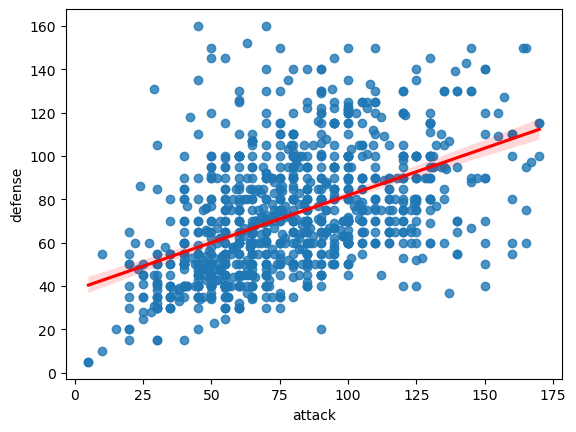

In [14]:
for idx1 in range(len(cols)):
    for idx2 in range(idx1+1, len(cols)):
        sns.regplot(x=cols[idx1], y=cols[idx2], data=remove_outliers(data, [cols[idx1], cols[idx2]]), line_kws={'color':'red'})
        plt.show()

<AxesSubplot:>

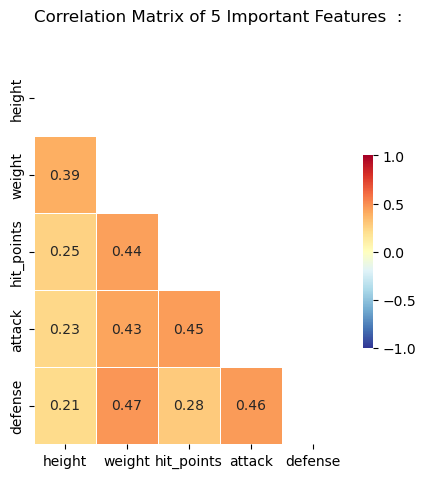

In [15]:
fig, axes = plt.subplots(figsize = (5,5))
fig.suptitle('Correlation Matrix of 5 Important Features  : ')

corrs = data[['height', 'weight', 'hit_points', 'attack', 'defense']].corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    data=corrs,
    annot=True,
    mask=mask,
    linewidths=.5,
    cmap = 'RdYlBu_r',
    cbar_kws={"shrink":.5},
    vmin = -1, vmax = 1,
)

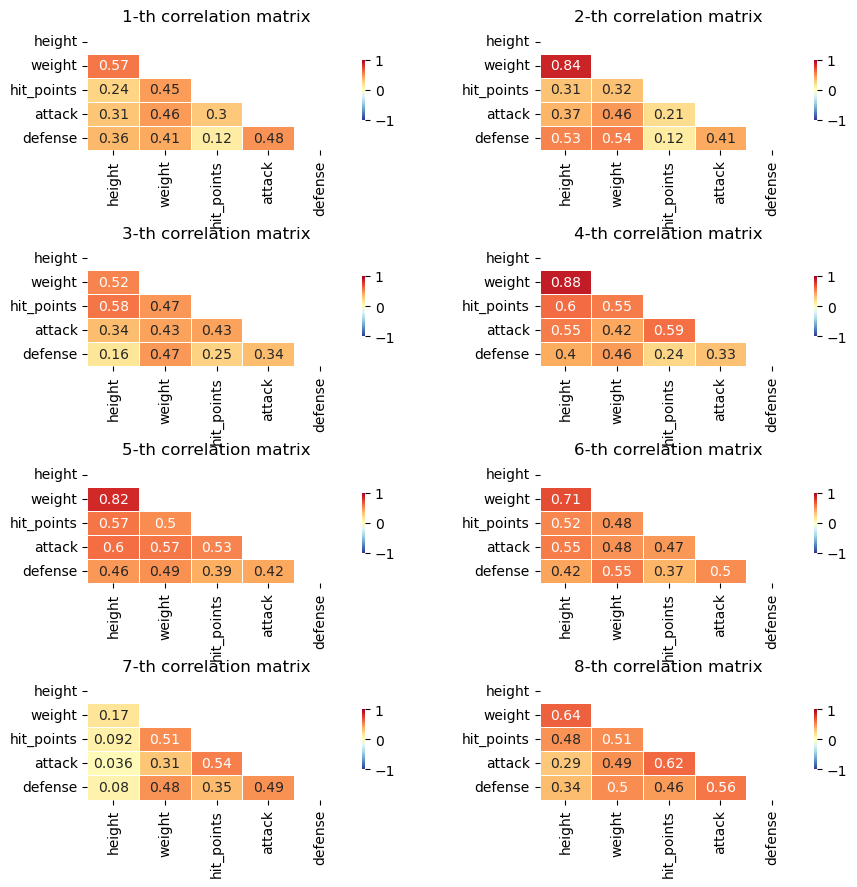

In [16]:
"""
reference
- https://m.blog.naver.com/kiddwannabe/221763497317
"""

Y = 4
X = 2
fig.suptitle('Correlation Matrix of 5 Important Features  : ')
fig, axes = plt.subplots(Y, X, figsize = (10,10))
plt.subplots_adjust(wspace=0.4, hspace = 0.8)

corrs = [gens[idx][['height', 'weight', 'hit_points', 'attack', 'defense']].corr() for idx in range(8)]
mask = np.zeros_like(corrs[0])
mask[np.triu_indices_from(mask)] = True

for y in range(Y):
    for x in range(X):        
        axes[y,x].set_title(f"{y*X + x + 1}-th correlation matrix")
        sns.heatmap(
            ax = axes[y,x],
            data=corrs[y*X + x],
            annot=True,
            mask=mask,
            linewidths=.5,
            cmap = 'RdYlBu_r',
            cbar_kws={"shrink":.5},
            vmin = -1, vmax = 1,
        )
plt.show()


# 1-2) How to these relationships evolve over generations of Pokemon

<AxesSubplot:xlabel='generation', ylabel='weight'>

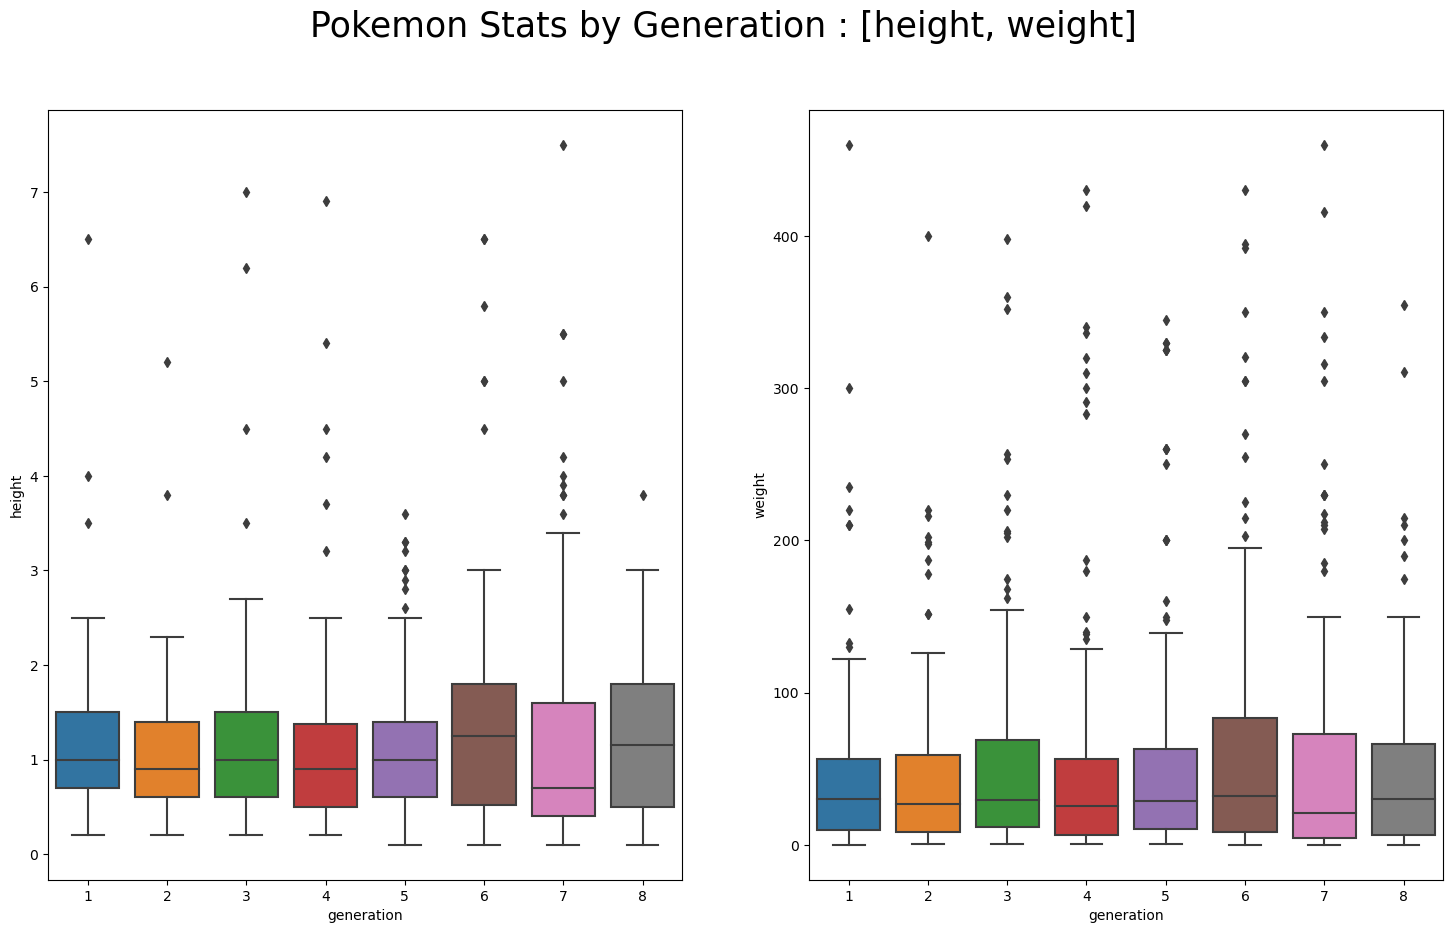

In [17]:
fig, axes = plt.subplots(1,2, figsize=(18, 10))

fig.suptitle('Pokemon Stats by Generation : [height, weight]', size=25)
sns.boxplot(ax=axes[0], data=remove_outliers(data, ['height']), x='generation', y='height')
sns.boxplot(ax=axes[1], data=remove_outliers(data, ['weight']), x='generation', y='weight')

<AxesSubplot:xlabel='generation', ylabel='speed'>

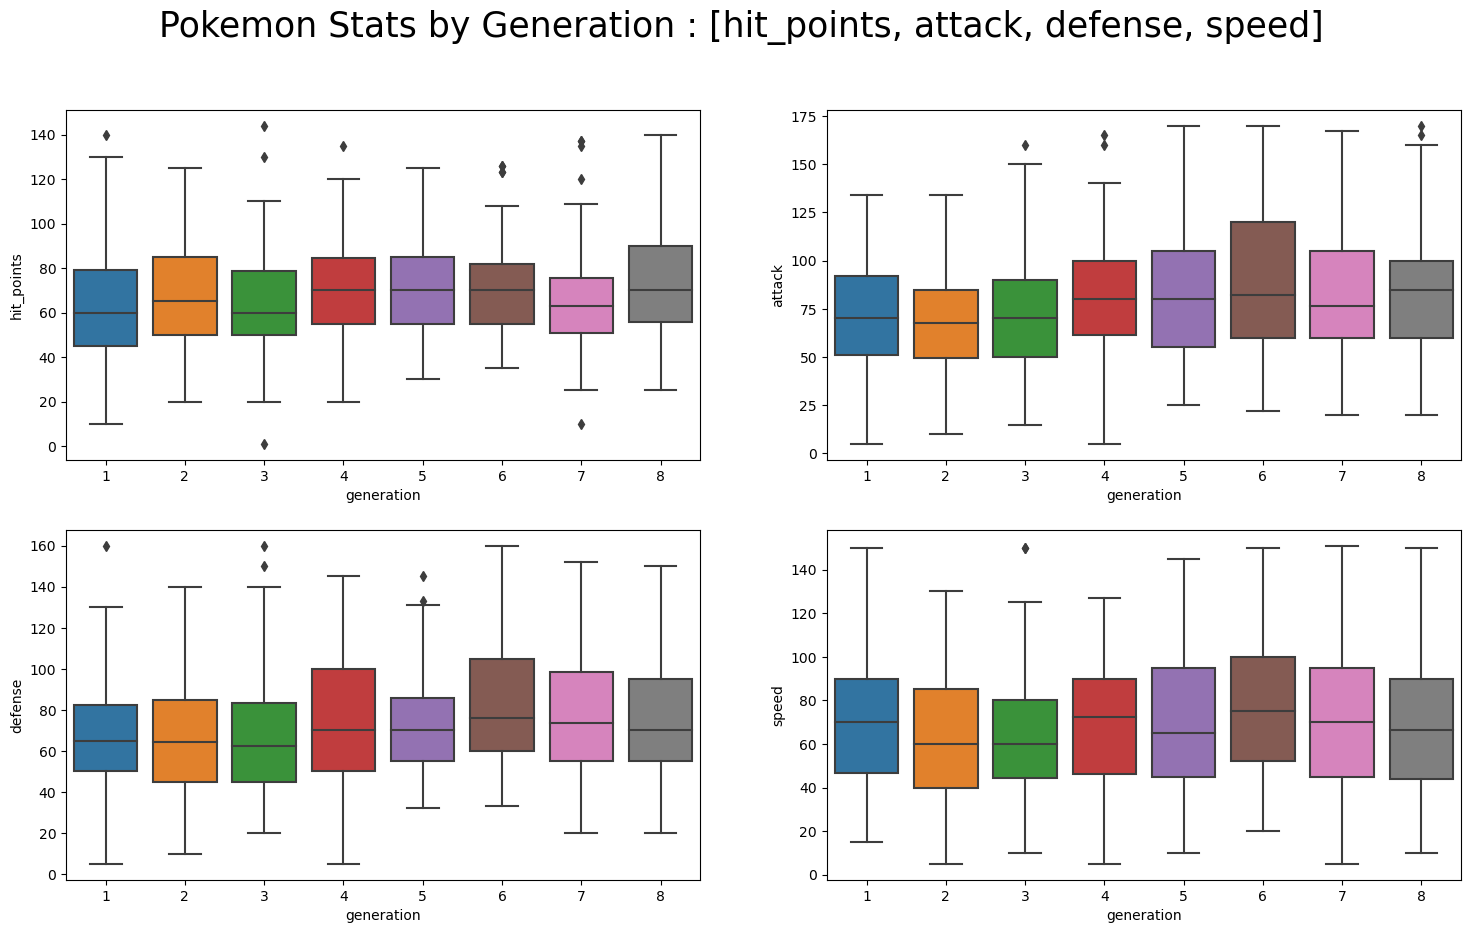

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Pokemon Stats by Generation : [hit_points, attack, defense, speed]', size= 25)
sns.boxplot(ax=axes[0, 0], data=remove_outliers(data, ['hit_points']), x='generation', y='hit_points')
sns.boxplot(ax=axes[0, 1], data=remove_outliers(data, ['attack']), x='generation', y='attack')
sns.boxplot(ax=axes[1, 0], data=remove_outliers(data, ['defense']), x='generation', y='defense')
sns.boxplot(ax=axes[1, 1], data=remove_outliers(data, ['speed']), x='generation', y='speed')


# 1-3) Which attributes significantly explain why certain Pokemon characters are classified as legendary or mythical?

In [19]:
data.columns

Index(['pokedex_number', 'pokemon_name', 'type_1', 'type_2', 'ability_1',
       'ability_2', 'ability_3', 'number_pokemon_with_typing', 'primary_color',
       'shape', 'height', 'weight', 'bmi', 'hit_points', 'attack', 'defense',
       'special_attack', 'special_defense', 'speed', 'total_stats', 'mean',
       'standard_deviation', 'capture_rate', 'generation', 'base_happiness',
       'base_experience', 'exp_type', 'exp_to_level_100', 'can_evolve',
       'evolves_from', 'final_evolution', 'mega_evolution', 'is_default',
       'baby_pokemon', 'alolan_form', 'galarian_form', 'forms_switchable',
       'legendary', 'mythical', 'genderless', 'female_rate', 'genus',
       'egg_group_1', 'egg_group_2', 'egg_cycles', 'against_normal',
       'against_fire', 'against_water', 'against_electric', 'against_grass',
       'against_ice', 'against_fighting', 'against_poison', 'against_ground',
       'against_flying', 'against_psychic', 'against_bug', 'against_rock',
       'against_ghost', '

## set feature / target columns 

In [20]:
# usesless columns
names = [
    'pokedex_number', 
    'pokemon_name', 
    'number_pokemon_with_typing', 
    'evolves_from',
    'base_experience',
    'exp_to_level_100',
]
redundant = [
    'bmi', 
    'total_stats', 
    'mean', 
    'standard_deviation',
    'genderless',
]
useless = names + redundant


# Y : targets
target_columns = [
    'legendary',
    'mythical',
]

# X : features
categorical = []
continuous  = []


In [21]:
for col in data.columns:
    if col in useless:
        continue
    if col in target_columns:
        continue
        
    if (data[col].dtype in [np.int64, np.float64]):
        if len(data[col].unique()) < 3: 
            categorical.append(col)
        else:
            continuous.append(col)
    elif (data[col].dtype in['object', 'bool']) | (col == 'exp_to_level_100'):
        categorical.append(col)

In [24]:
X = data[continuous+categorical].fillna('')
Y = np.where(data[target_columns].T.sum() >= 1, 1, 0) # either 'lenendary' or 'mythycal' or both

In [25]:
split_point = int(len(X)*0.7)
X_train, X_test = X[:split_point-1], X[split_point:]
Y_train, Y_test = Y[:split_point-1], Y[split_point:]

#### encoding categorical variable

In [26]:
# label encoding for categorical variables

encoders = []

# for train
for idx in range(len(categorical)):
    encoder = LabelEncoder()
    X_train[categorical[idx]] = encoder.fit_transform(X_train[categorical[idx]])
    encoders.append(encoder)

# for test
for idx in range(len(categorical)):
    for label in np.unique(X_test[categorical[idx]]):
        if label not in encoders[idx].classes_: # handling unseen labels 
            encoders[idx].classes_ = np.append(encoders[idx].classes_, label) # to prevent ValueError from appearing
    X_test[categorical[idx]] = encoders[idx].transform(X_test[categorical[idx]])


In [27]:
"""
categorical[0] : type_1
categorical[1] : type_2

encoders[0] -> type_1 encoder
encoders[1] -> type_2 encoder
"""
print()

In [28]:
print(len(X_train), len(Y_train), len(X_test), len(Y_test))

757 757 325 325


# Classifier

#### SVM Classifier

In [29]:
SVM_model = SVC()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
SVM_param_grid = [
    {
        'C' : [0.001, 0.01, 0.1, 1, 10, 100],
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree' : [1,2,3,4],
    }
]
SVM_grid_search = GridSearchCV(
    estimator=SVM_model,
    param_grid=SVM_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

SVM_grid_search.fit(X_train, Y_train)

Fitting 6 folds for each of 96 candidates, totalling 576 fits


GridSearchCV(cv=KFold(n_splits=6, random_state=1203, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'degree': [1, 2, 3, 4],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             verbose=2)

In [30]:
print(SVM_grid_search.best_params_)
print("SVM train score : ", SVM_grid_search.best_score_)
print("SVM test  score : ", SVM_grid_search.score(X_test, Y_test))
SVM_top_10_features = pd.DataFrame(SVM_grid_search.best_estimator_.coef_, columns = continuous + categorical).T.abs().sort_values(0, ascending=False)[:10]
SVM_top_10_features.columns = ['importance']
SVM_top_10_features

{'C': 0.001, 'degree': 1, 'kernel': 'linear'}
SVM train score :  0.996031746031746
SVM test  score :  0.96


,importance
capture_rate,0.052288
egg_cycles,0.032983
egg_group_1,0.018501
ability_2,0.014324
defense,0.014083
ability_3,0.009739
hit_points,0.009655
shape,0.009620
type_2,0.009323
speed,0.008728


#### RandomForest Classifier

In [31]:
RF_model = RandomForestClassifier()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
RF_param_grid = [
    {
        'n_estimators' : [10, 50, 100, 150, 200],
        'max_depth' : [1,2,3,4],
    }
]
RF_grid_search = GridSearchCV(
    estimator=RF_model,
    param_grid=RF_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

RF_grid_search.fit(X_train, Y_train)

Fitting 6 folds for each of 20 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=6, random_state=1203, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_depth': [1, 2, 3, 4],
                          'n_estimators': [10, 50, 100, 150, 200]}],
             verbose=2)

In [32]:
print(RF_grid_search.best_params_)
print("RF train score : ", RF_grid_search.best_score_)
print("RF test  score : ", RF_grid_search.score(X_test, Y_test))
RF_top_10_features = pd.DataFrame(RF_grid_search.best_estimator_.feature_importances_.reshape(1, -1), columns = continuous + categorical).T.sort_values(0, ascending=False)[:10]
RF_top_10_features.columns = ['importance']
RF_top_10_features

{'max_depth': 3, 'n_estimators': 150}
RF train score :  0.9973544973544973
RF test  score :  0.9815384615384616


,importance
egg_cycles,0.290494
capture_rate,0.193029
base_happiness,0.099242
exp_type,0.067887
egg_group_1,0.064326
female_rate,0.063033
special_attack,0.033892
height,0.023671
ability_2,0.021989
special_defense,0.021961


#### Logistic Classifier

In [33]:
LR_model = LogisticRegression()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
LR_param_grid = [
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C' : [0.01, 0.1, 1, 10, 100],
        'solver' : ['lbfgs', 'liblinear', 'newton=cg', 'saga']
    }
]
LR_grid_search = GridSearchCV(
    estimator=LR_model,
    param_grid=LR_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

LR_grid_search.fit(X_train, Y_train)

Fitting 6 folds for each of 60 candidates, totalling 360 fits


GridSearchCV(cv=KFold(n_splits=6, random_state=1203, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['lbfgs', 'liblinear', 'newton=cg',
                                     'saga']}],
             verbose=2)

In [34]:
print(LR_grid_search.best_params_)
print("LR train score : ", LR_grid_search.best_score_)
print("LR test  score : ", LR_grid_search.score(X_test, Y_test))
LR_top_10_features = pd.DataFrame(LR_grid_search.best_estimator_.coef_, columns = continuous + categorical).T.abs().sort_values(0, ascending=False)[:10]
LR_top_10_features.columns = ['importance']
LR_top_10_features

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
LR train score :  0.996031746031746
LR test  score :  0.9569230769230769


,importance
against_fire,4.240203
against_dark,1.907304
generation,0.734050
egg_group_1,0.710112
against_electric,0.573263
ability_3,0.442018
capture_rate,0.403542
primary_color,0.360909
type_1,0.217715
egg_cycles,0.207992


In [35]:
important_features = SVM_top_10_features.index.tolist() + RF_top_10_features.index.tolist() +LR_top_10_features.index.tolist()
important_features = list(set(important_features)) + ['legendary']
data[[feature for feature in important_features]].corr()

,special_defense,female_rate,speed,against_fire,base_happiness,against_dark,special_attack,egg_cycles,generation,defense,height,hit_points,capture_rate,against_electric,legendary
special_defense,1.000000,-0.211505,0.201935,-0.009328,-0.145520,0.141820,0.504922,0.335482,0.101091,0.535906,0.201070,0.366688,-0.507863,0.017617,0.308029
female_rate,-0.211505,1.000000,-0.248515,0.098333,0.318822,-0.045107,-0.307414,-0.510623,-0.059780,-0.204374,-0.111061,-0.143209,0.369651,-0.036215,-0.437219
speed,0.201935,-0.248515,1.000000,-0.116652,-0.171378,0.008443,0.435199,0.331498,0.086571,-0.021537,0.066850,0.162200,-0.396239,0.094364,0.286410
against_fire,-0.009328,0.098333,-0.116652,1.000000,0.023706,0.016557,-0.114687,-0.048916,0.038975,0.055665,-0.022159,-0.094212,0.062107,-0.261412,-0.052164
base_happiness,-0.145520,0.318822,-0.171378,0.023706,1.000000,0.013416,-0.244765,-0.546911,-0.199063,-0.206693,-0.209643,-0.158625,0.169350,0.049241,-0.483808
against_dark,0.141820,-0.045107,0.008443,0.016557,0.013416,1.000000,0.201955,0.175865,0.012491,0.057622,-0.012024,0.010406,-0.038002,-0.038993,0.108515
special_attack,0.504922,-0.307414,0.435199,-0.114687,-0.244765,0.201955,1.000000,0.430229,0.112049,0.223139,0.230911,0.372227,-0.511298,0.015746,0.360518
egg_cycles,0.335482,-0.510623,0.331498,-0.048916,-0.546911,0.175865,0.430229,1.000000,0.144381,0.280413,0.236964,0.386242,-0.375423,-0.072230,0.803470
generation,0.101091,-0.059780,0.086571,0.038975,-0.199063,0.012491,0.112049,0.144381,1.000000,0.116815,0.065983,0.067919,-0.072362,-0.074397,0.152908
defense,0.535906,-0.204374,-0.021537,0.055665,-0.206693,0.057622,0.223139,0.280413,0.116815,1.000000,0.213666,0.283488,-0.440435,-0.085206,0.248098


<AxesSubplot:>

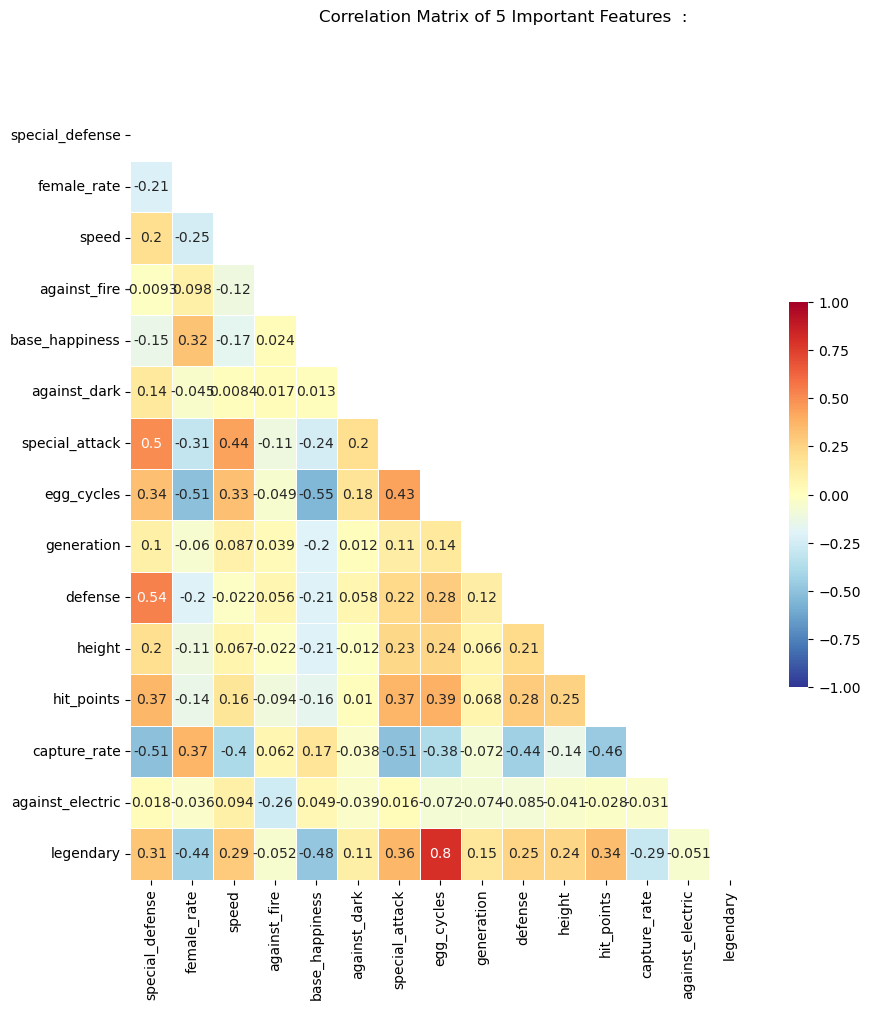

In [36]:
fig, axes = plt.subplots(figsize = (10,10))
fig.suptitle('Correlation Matrix of 5 Important Features  : ')

corrs = data[[feature for feature in important_features]].corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    data=corrs,
    annot=True,
    mask=mask,
    linewidths=.5,
    cmap = 'RdYlBu_r',
    cbar_kws={"shrink":.5},
    vmin = -1, vmax = 1,
)

## Type Classifier

In [37]:
new_X_train = X_train.drop(columns=['type_1', 'type_2'])
new_X_test = X_test.drop(columns=['type_1', 'type_2'])

new_type1_train = X_train[['type_1']]
new_type2_train = X_train[['type_2']]

new_type1_test = X_test[['type_1']]
new_type2_test = X_test[['type_2']]

### SVC

In [39]:
SVM_model = SVC()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
SVM_param_grid = [
    {
        'C' : [0.001, 0.01, 0.1, 1, 10, 100],
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree' : [1,2,3,4],
    }
]
SVM_type1_classifier = GridSearchCV(
    estimator=SVM_model,
    param_grid=SVM_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

SVM_type1_classifier.fit(new_X_train, new_type1_train)
print(SVM_type1_classifier.best_params_)
print("SVM train score : ", SVM_type1_classifier.best_score_)
print("SVM test  score : ", SVM_type1_classifier.score(new_X_test, new_type1_test))

Fitting 6 folds for each of 96 candidates, totalling 576 fits
{'C': 1, 'degree': 1, 'kernel': 'linear'}
SVM train score :  0.7146502520518269
SVM test  score :  0.36615384615384616


In [40]:
SVM_model = SVC()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
SVM_param_grid = [
    {
        'C' : [0.001, 0.01, 0.1, 1, 10, 100],
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree' : [1,2,3,4],
    }
]
SVM_type2_classifier = GridSearchCV(
    estimator=SVM_model,
    param_grid=SVM_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

SVM_type2_classifier.fit(new_X_train, new_type2_train)
print(SVM_type2_classifier.best_params_)
print("SVM train score : ", SVM_type2_classifier.best_score_)
print("SVM test  score : ", SVM_type2_classifier.score(new_X_test, new_type2_test))

Fitting 6 folds for each of 96 candidates, totalling 576 fits
{'C': 1, 'degree': 1, 'kernel': 'linear'}
SVM train score :  0.6724680248302296
SVM test  score :  0.3446153846153846


### RF

In [55]:
RF_model = RandomForestClassifier()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
RF_param_grid = [
    {
        'n_estimators' : [10, 50, 100, 150, 200],
        'max_depth' : [1,2,3,4],
    }
]
RF_type1_classifier = GridSearchCV(
    estimator=RF_model,
    param_grid=RF_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

RF_type1_classifier.fit(new_X_train, new_type1_train)
print(RF_type1_classifier.best_params_)
print("RF train score : ", RF_type1_classifier.best_score_)
print("RF test  score : ", RF_type1_classifier.score(new_X_test, new_type1_test))

Fitting 6 folds for each of 20 candidates, totalling 120 fits
{'max_depth': 4, 'n_estimators': 200}
RF train score :  0.8784631087780695
RF test  score :  0.7630769230769231


In [56]:
RF_model = RandomForestClassifier()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
RF_param_grid = [
    {
        'n_estimators' : [10, 50, 100, 150, 200],
        'max_depth' : [1,2,3,4],
    }
]
RF_type2_classifier = GridSearchCV(
    estimator=RF_model,
    param_grid=RF_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

RF_type2_classifier.fit(new_X_train, new_type2_train)
print(RF_type2_classifier.best_params_)
print("RF train score : ", RF_type2_classifier.best_score_)
print("RF test  score : ", RF_type2_classifier.score(new_X_test, new_type2_test))

Fitting 6 folds for each of 20 candidates, totalling 120 fits
{'max_depth': 4, 'n_estimators': 150}
RF train score :  0.6908407282423031
RF test  score :  0.48923076923076925


### LR

In [57]:
LR_model = LogisticRegression()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
LR_param_grid = [
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C' : [0.01, 0.1, 1, 10, 100],
        'solver' : ['lbfgs', 'liblinear', 'newton=cg', 'saga']
    }
]
LR_type1_classifier = GridSearchCV(
    estimator=LR_model,
    param_grid=LR_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

LR_type1_classifier.fit(new_X_train, new_type1_train)
print(LR_type1_classifier.best_params_)
print("LR train score : ", LR_type1_classifier.best_score_)
print("LR test  score : ", LR_type1_classifier.score(new_X_test, new_type1_test))

Fitting 6 folds for each of 60 candidates, totalling 360 fits
{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
LR train score :  0.9272799233429154
LR test  score :  0.6215384615384615


In [58]:
LR_model = LogisticRegression()

Kf = KFold(random_state = 1203,
          n_splits=6,
          shuffle = True
)
LR_param_grid = [
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C' : [0.01, 0.1, 1, 10, 100],
        'solver' : ['lbfgs', 'liblinear', 'newton=cg', 'saga']
    }
]
LR_type2_classifier = GridSearchCV(
    estimator=LR_model,
    param_grid=LR_param_grid,
    cv=Kf,
    n_jobs=-1, 
    verbose=2
)

LR_type2_classifier.fit(new_X_train, new_type2_train)
print(LR_type2_classifier.best_params_)
print("LR train score : ", LR_type2_classifier.best_score_)
print("LR test  score : ", LR_type2_classifier.score(new_X_test, new_type2_test))

Fitting 6 folds for each of 60 candidates, totalling 360 fits
{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
LR train score :  0.8480502437195351
LR test  score :  0.5076923076923077


### Add noise

In [60]:
import pandas as pd
import numpy as np

def add_noise_continuous(df, std=0.1):
    """
    Add Gaussian noise to each column of a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to add noise to.
    std (float): The standard deviation of the Gaussian noise to add. Default is 0.1.

    Returns:
    pandas.DataFrame: A new DataFrame with noise added to each column.
    """

    # Make a copy of the original DataFrame to avoid modifying it
    noisy_df = df.copy()

    # Loop through the columns and add Gaussian noise
    for col in noisy_df.columns:
        noise = np.random.normal(scale=std, size=len(df))
        noisy_df[col] = noisy_df[col] + noise

    # Return the new DataFrame with noise added
    return noisy_df

In [61]:
def shuffle_category_values(df):
    """
    Shuffle the values of each category column in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to shuffle.

    Returns:
    pandas.DataFrame: A new DataFrame with the values of each category column shuffled.
    """

    # Make a copy of the original DataFrame to avoid modifying it
    shuffled_df = df.copy()

    # Loop through the columns and shuffle the category values
    for col in shuffled_df.columns:
        if shuffled_df[col].dtype.name == 'category':
            categories = shuffled_df[col].cat.categories
            shuffled_categories = np.random.permutation(categories)
            shuffled_df[col] = shuffled_df[col].cat.set_categories(shuffled_categories)

    # Return the new DataFrame with the values of each category column shuffled
    return shuffled_df

### generate pokemon

In [76]:
cat_columns = ['ability_1', 'ability_2', 'ability_3', 
                 'primary_color', 'shape', 'exp_type', 
                 'can_evolve', 'final_evolution', 
                 'mega_evolution','is_default', 'baby_pokemon', 
                 'alolan_form', 'galarian_form',
           'forms_switchable', 'genus', 'egg_group_1',
                 'egg_group_2']

new_continuous_X = add_noise_continuous(
    pd.concat([
        new_X_train[[feature for feature in continuous]], 
        new_X_test[[feature for feature in continuous]]], 0)
)
new_categorical_X = shuffle_category_values(pd.concat([
    new_X_train[cat_columns],
    new_X_test[cat_columns]], 0)
)

X_for_generation = pd.concat(
    [new_continuous_X, new_categorical_X], axis=1)
Y1_for_generation = pd.DataFrame(
    RF_type1_classifier.predict(X_for_generation), 
    columns=['type_1'])
Y2_for_generation = pd.DataFrame(
    LR_type2_classifier.predict(X_for_generation), 
    columns=['type_2'])
generated = pd.concat(
    [X_for_generation, 
     Y1_for_generation, 
     Y2_for_generation], 1).dropna()
generated.head(5)

,height,weight,hit_points,attack,defense,special_attack,special_defense,speed,capture_rate,generation,base_happiness,female_rate,egg_cycles,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fighting,against_poison,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy,ability_1,ability_2,ability_3,primary_color,shape,exp_type,can_evolve,final_evolution,mega_evolution,is_default,baby_pokemon,alolan_form,galarian_form,forms_switchable,genus,egg_group_1,egg_group_2,type_1,type_2
0,0.723146,6.879048,44.965096,48.998270,49.148279,65.041680,64.873462,44.905462,44.897259,0.931177,70.060993,0.173978,20.009829,1.030851,1.927579,0.436449,0.501084,0.199344,1.962026,0.394558,0.901691,0.809490,1.933143,1.809193,1.034822,1.179144,1.120628,0.854640,0.837644,1.036946,0.689994,75.0,9.0,0.0,4.0,9.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,355.0,10.0,7.0,8.0,14.0
1,0.907837,12.950507,59.933953,61.971962,62.861793,79.849635,80.142589,59.926477,45.169083,1.026282,69.924370,-0.017852,20.071436,1.083896,1.959414,0.464000,0.485420,0.035433,2.002239,0.491115,1.067026,1.088410,2.030589,2.055622,0.856728,0.961927,1.163220,0.916836,1.003208,0.955947,0.466798,75.0,9.0,0.0,4.0,9.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,355.0,10.0,7.0,8.0,14.0
2,2.443139,155.459844,79.991926,100.019099,122.987146,121.831851,119.935396,79.976016,44.989099,5.921001,69.993475,0.106535,19.848837,1.058126,2.003639,0.415499,0.497978,0.132460,1.988754,0.405140,0.881497,0.975784,2.102990,2.075830,1.032557,1.120118,1.046817,1.065088,0.982182,1.042767,0.413077,127.0,0.0,0.0,4.0,9.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,355.0,10.0,7.0,8.0,14.0
3,1.879659,99.922281,79.936934,81.891836,83.028626,100.101396,100.042057,79.930262,44.805562,0.988184,70.068991,0.151255,19.944752,1.164708,2.185616,0.481013,0.682375,0.060809,1.984815,0.311257,0.994686,1.109743,2.175279,2.028043,0.852642,1.042780,1.195700,0.922651,0.866591,0.984139,0.559159,75.0,9.0,0.0,4.0,9.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,355.0,10.0,7.0,8.0,14.0
4,0.554202,8.547634,38.946514,52.103185,43.001285,59.947964,49.802099,64.939783,44.925291,1.063742,69.893813,0.115855,20.110551,1.187623,0.476756,2.065103,1.037140,0.492590,0.450544,1.002481,1.039960,2.236841,0.731953,0.843013,0.675539,2.194614,0.978780,1.099746,1.070060,0.295298,0.440722,9.0,104.0,0.0,7.0,12.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,240.0,10.0,3.0,6.0,0.0


,height,weight,hit_points,attack,defense,special_attack,special_defense,speed,capture_rate,generation,base_happiness,female_rate,egg_cycles,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fighting,against_poison,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy,ability_1,ability_2,ability_3,primary_color,shape,exp_type,can_evolve,final_evolution,mega_evolution,is_default,baby_pokemon,alolan_form,galarian_form,forms_switchable,genus,egg_group_1,egg_group_2,type_1,type_2
0,0.766129,6.823302,45.210058,49.012481,48.962098,64.866932,64.943634,44.987750,44.894327,0.840485,70.223296,0.057563,20.085156,0.946578,2.039649,0.449371,0.602397,0.303031,1.874720,0.358209,0.801127,1.070739,1.910970,1.897098,0.889276,1.058828,1.180183,0.934136,1.024430,0.992184,0.511387,75.0,9.0,0.0,4.0,9.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,355.0,10.0,7.0,8.0,14.0
1,0.980184,12.990184,60.164924,61.968073,63.038391,80.071452,80.137831,60.037770,45.014013,1.046979,70.130556,0.059119,20.094644,0.997783,2.158111,0.520881,0.470583,0.398098,2.045336,0.578549,1.011979,1.080554,2.020455,1.950938,1.200050,1.078190,1.064792,1.354865,1.020563,1.275312,0.389571,75.0,9.0,0.0,4.0,9.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,355.0,10.0,7.0,8.0,14.0
2,2.268678,155.385688,79.903329,100.152464,122.993150,122.123417,119.906183,80.122771,45.094517,5.969414,70.180731,0.333411,20.014593,1.060845,2.062203,0.507282,0.526109,0.153519,1.857950,0.386473,0.984485,1.045166,2.224079,2.173569,1.020290,0.988624,0.976856,0.996314,0.990199,0.962236,0.613285,127.0,0.0,0.0,4.0,9.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,355.0,10.0,7.0,8.0,14.0
3,2.065665,100.042453,79.931855,82.043480,82.879698,99.876225,99.991372,80.016954,44.871566,0.819341,70.020585,0.231966,19.790353,0.983340,1.959826,0.405078,0.534192,0.306403,2.014360,0.469911,0.838997,0.907519,2.064767,2.049502,0.885126,0.786353,0.905015,1.063965,0.933013,0.962375,0.343989,75.0,9.0,0.0,4.0,9.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,355.0,10.0,7.0,8.0,14.0
4,0.595261,8.568133,38.923143,52.036875,42.964999,59.886730,50.231281,65.030362,45.139521,1.022664,69.825670,0.126797,20.047586,1.141284,0.475613,2.088007,1.112457,0.619670,0.381884,0.987494,0.966798,1.746275,0.988673,1.024615,0.539374,2.165368,0.895740,1.059333,1.042497,0.434336,0.363063,9.0,104.0,0.0,7.0,12.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,240.0,10.0,3.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,2.126084,200.188357,200.107115,99.915548,50.220819,99.868497,50.130172,80.020798,2.882622,7.911286,34.852114,-0.018783,120.146031,0.911183,0.263170,0.537369,0.544243,0.400971,2.050381,0.941961,1.162792,0.896539,0.920862,1.020440,1.061112,0.956560,1.098683,2.046382,0.959284,0.956076,1.924647,162.0,0.0,0.0,4.0,7.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,512.0,11.0,0.0,10.0,0.0
1078,2.183367,800.167153,99.972076,144.934526,130.088774,65.056209,110.099581,30.127147,2.983368,7.957503,35.089157,0.024895,120.007296,0.980017,2.083150,1.018900,1.031081,0.919235,0.329039,2.184471,1.061461,0.920528,1.073622,1.028818,1.083696,2.059946,0.893228,0.910679,1.013526,2.022226,1.032149,151.0,0.0,0.0,8.0,9.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,638.0,11.0,0.0,7.0,9.0
1079,1.976905,44.531245,100.071751,64.922215,60.088221,145.036546,80.010300,129.968680,3.029726,7.978756,34.917643,0.128916,119.746026,-0.031394,0.953594,0.827211,1.127078,1.100550,1.015435,0.089143,0.576437,1.175217,1.056769,1.152273,0.448718,1.185532,2.081138,1.051768,1.921622,1.009617,0.917750,171.0,0.0,0.0,0.0,9.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,619.0,11.0,0.0,8.0,10.0
1080,1.229000,7.795592,100.085069,79.977049,80.134758,80.199558,80.241364,80.127007,3.069651,7.942349,99.865503,-0.005813,120.088351,1.005441,2.102077,0.470906,0.514204,0.535477,1.95